In [1]:
import math
import random
import decimal
import scipy.linalg
import numpy.random as nrand 
import gpflow
import numpy as np
import GPy, numpy as np, pandas as pd
from GPy.kern import LinearSlopeBasisFuncKernel, DomainKernel, ChangePointBasisFuncKernel
from matplotlib import pyplot as plt
from timeit import default_timer as timer


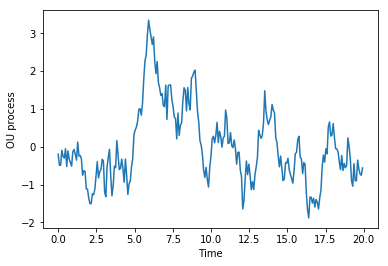

In [2]:
x=np.loadtxt("test.txt")
#Standardize the data
x=(x-np.mean(x))/np.std(x)
dt=0.08
time=np.arange(0,20,dt)# time
sigma=2
a=1# the coefficient in front, the rate
b=0# the mean
#Simulation of an OU process
#x=ou_values(a,b,dt,sigma,time)
t=time# time vector
plt.plot(t,x)
plt.xlabel('Time')
plt.ylabel('OU process')
plt.show()

In [3]:
t_column=t.reshape(-1,1)
x_column=x.reshape(-1,1)

In [4]:
with gpflow.defer_build():
    k=gpflow.kernels.Matern12(1, lengthscales=10)
    m = gpflow.models.GPR(t_column,x_column, k)
    m.likelihood.variance = 0.1
    m.kern.variance=1

In [5]:
m.kern.lengthscales.prior = gpflow.priors.Gamma(1, 1.)
m.kern.variance.prior = gpflow.priors.Gamma(1, 1.)
m.likelihood.variance.prior = gpflow.priors.Gamma(1, 1.)
#m.kern.variance.trainable=True
m.compile()
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/lengthscales,Parameter,"Ga(1.0,1.0)",+ve,True,(),True,10.0
GPR/kern/variance,Parameter,"Ga(1.0,1.0)",+ve,True,(),True,1.0
GPR/likelihood/variance,Parameter,"Ga(1.0,1.0)",+ve,True,(),True,0.1


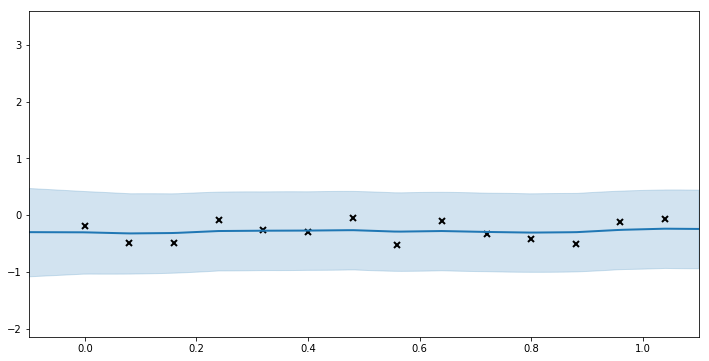

In [6]:
def plot(m):
    xx = np.linspace(-0.1, 1.1, 100).reshape(100, 1)
    mean, var = m.predict_y(xx)
    plt.figure(figsize=(12, 6))
    plt.plot(t, x, 'kx', mew=2)
    plt.plot(xx, mean, 'C0', lw=2)
    plt.fill_between(xx[:,0],
                     mean[:,0] - 2*np.sqrt(var[:,0]),
                     mean[:,0] + 2*np.sqrt(var[:,0]),
                     color='C0', alpha=0.2)
    plt.xlim(-0.1, 1.1)

plot(m)


In [7]:
# MAP GPflow and also time it
start = timer()
gpflow.train.ScipyOptimizer().minimize(m)
elapsed_time = timer()
print(elapsed_time)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 102.545964
  Number of iterations: 20
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 102.545964
  Number of iterations: 20
  Number of functions evaluations: 26


1.2112832745547557


,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/lengthscales,Parameter,"Ga(1.0,1.0)",+ve,True,(),True,1.194463580996997
GPR/kern/variance,Parameter,"Ga(1.0,1.0)",+ve,True,(),True,0.8604428221636335
GPR/likelihood/variance,Parameter,"Ga(1.0,1.0)",+ve,True,(),True,0.00940264966251011


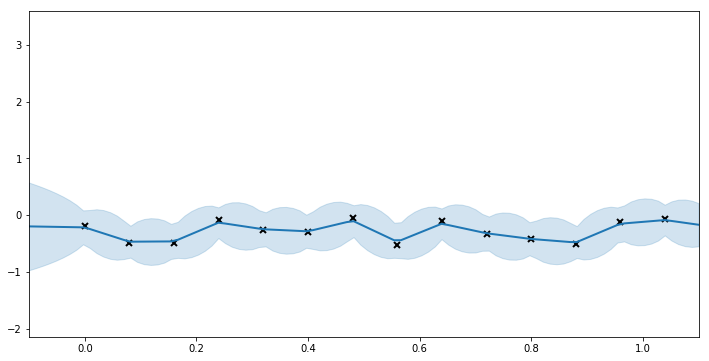

In [8]:
plot(m)
m.as_pandas_table()

 C:\Users\Ionut\Anaconda3\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


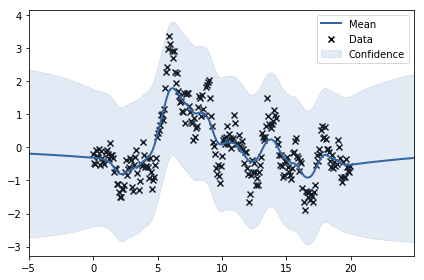

In [9]:
#MAP GPy
k1=GPy.kern.Exponential(1,variance=1,lengthscale=10)
# Make a GP regression model
m1 = GPy.models.GPRegression(t_column,x_column,k1)
# Give some general prior distributions for model parameters
m1.kern.lengthscale.set_prior(GPy.priors.Gamma.from_EV(1.,1))
m1.kern.variance.set_prior(GPy.priors.Gamma.from_EV(1.,1))
m1.likelihood.variance.set_prior(GPy.priors.Gamma.from_EV(1.,1))
_=m1.plot()


In [10]:
print(m1) 
# Look at the order of the parameters variance, lengthscales and then noise variance


Name : GP regression
Objective : 305.09600278234734
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |   priors 
  Exponential.variance     |    1.0  |      +ve      |  Ga(1, 1)
  Exponential.lengthscale  |   10.0  |      +ve      |  Ga(1, 1)
  Gaussian_noise.variance  |    1.0  |      +ve      |  Ga(1, 1)


In [11]:
start = timer()
m1.optimize()
elapsed_time = timer()
print(elapsed_time)

2.136055254891751


In [12]:
print(m1)


Name : GP regression
Objective : 102.5458580035116
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                 value  |  constraints  |   priors 
  Exponential.variance     |    0.8604506455105784  |      +ve      |  Ga(1, 1)
  Exponential.lengthscale  |    1.1944727461432882  |      +ve      |  Ga(1, 1)
  Gaussian_noise.variance  |  0.009402333026467306  |      +ve      |  Ga(1, 1)


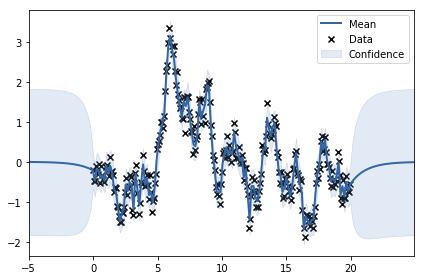

In [13]:
fig = m1.plot()

In [14]:
#HMC GPy(Hybrid Monte Carlo)
hmc = GPy.inference.mcmc.HMC(m1,stepsize=5e-2)
s = hmc.sample(num_samples=10000)
#print('acceptance rate: ', len(set(s))/len(s))
#s = samples.drop('logprobs', axis=1)
#I have no clue how to get acceptance rate

Text(0, 0.5, 'parameter value')

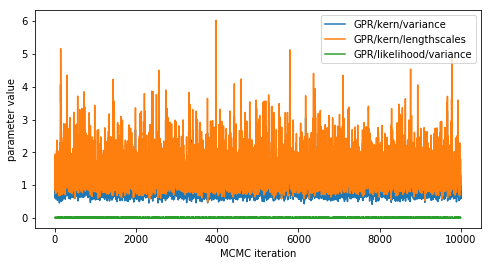

In [15]:
# transform s to pandas
A=s
variance_final_vector=[p[0] for p in A]# variance goes first in GPy
lengthscales_final_vector=[p[1] for p in A]
likelihood_variance_final_vector=[p[2] for p in A]
import pandas as pd
d = {'col1': variance_final_vector, 'col2':lengthscales_final_vector, 'col3':likelihood_variance_final_vector}
df = pd.DataFrame(data=d)#, dtype=np.int8)
df.columns=['GPR/kern/variance','GPR/kern/lengthscales','GPR/likelihood/variance']# changing the names
samples=df # rename it
plt.figure(figsize=(8,4))
for i, col in samples.iteritems():
    plt.plot(col, label=col.name)
plt.legend(loc=0)
plt.xlabel('MCMC iteration')
plt.ylabel('parameter value')

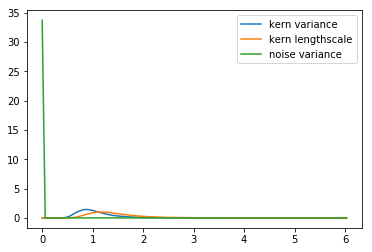

In [16]:
labels = ['kern variance', 'kern lengthscale','noise variance']
samples = s[1000:] # cut out the burn-in period
from scipy import stats
xmin = samples.min()
xmax = samples.max()
xs = np.linspace(xmin,xmax,100)
for i in range(samples.shape[1]):
    kernel = stats.gaussian_kde(samples[:,i])
    plt.plot(xs,kernel(xs),label=labels[i])
_ = plt.legend()

Text(0, 0.5, 'noise variance')

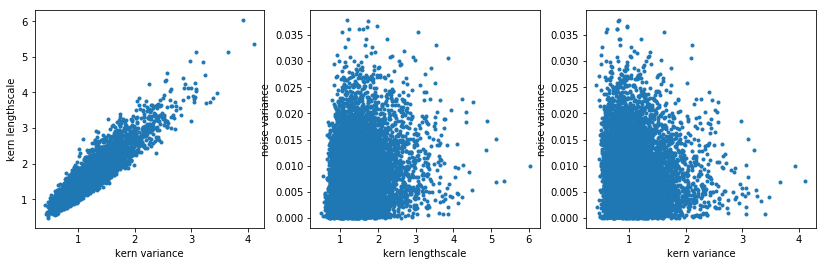

In [17]:
fig = plt.figure(figsize=(14,4))
ax = fig.add_subplot(131)
_=ax.plot(samples[:,0],samples[:,1],'.')
ax.set_xlabel(labels[0]); ax.set_ylabel(labels[1])
ax = fig.add_subplot(132)
_=ax.plot(samples[:,1],samples[:,2],'.')
ax.set_xlabel(labels[1]); ax.set_ylabel(labels[2])
ax = fig.add_subplot(133)
_=ax.plot(samples[:,0],samples[:,2],'.')
ax.set_xlabel(labels[0]); ax.set_ylabel(labels[2])


Name : GP regression
Objective : 102.81858038293173
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                 value  |  constraints  |   priors 
  Exponential.variance     |    1.0608289726178115  |      +ve      |  Ga(1, 1)
  Exponential.lengthscale  |    1.4490032838699365  |      +ve      |  Ga(1, 1)
  Gaussian_noise.variance  |  0.008206627532957252  |      +ve      |  Ga(1, 1)


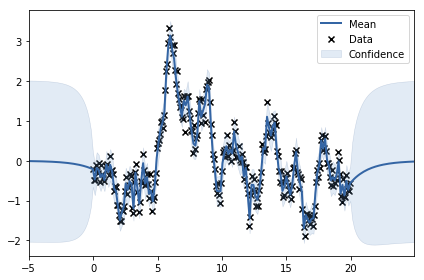

In [18]:
# Set the model parameters as the posterior mean
m1.kern.variance[:] = samples[:,0].mean()
m1.kern.lengthscale[:] = samples[:,1].mean()
m1.likelihood.variance[:] = samples[:,2].mean()
print(m1)
_=m1.plot()